In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from adjustText import adjust_text
from io import StringIO
import requests
from typing import List

from bbcstyle.theme import bbc_theme
from bbcstyle.finalise_plot import finalise_plot

### Support functions

In [2]:
def load_pensions_data(url: str) -> pd.DataFrame:
    """
    Fetch the pensions CSV from the URL using a browser-like User-Agent,
    load it into a DataFrame, rename columns to country, pop_over65, gov_spending,
    and drop any rows where gov_spending is missing.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text))
    df.columns = ["country", "pop_over65", "gov_spending"]
    return df.dropna(subset=["gov_spending"])


def get_oecd_countries(wiki_url: str) -> List[str]:
    """
    Fetch the current OECD member list table from the Wikipedia page at wiki_url,
    identify the table whose columns include "Country", and return the list of country names.
    """
    # read all tables on the page
    tables = pd.read_html(wiki_url, flavor="lxml")
    # find the first table that has a "Country" column
    for tbl in tables:
        if "Country" in tbl.columns:
            # strip whitespace and drop any NaNs
            return tbl["Country"].astype(str).str.strip().dropna().tolist()
    raise ValueError("Could not find a member-country table on the page")


def prepare_plot_data(
    pensions_df: pd.DataFrame,
    oecd_countries: List[str],
    highlight_countries: List[str],
) -> pd.DataFrame:
    """
    Take the raw pensions DataFrame and:
      • compute the OECD average as a new row
      • bind it back to the original data
      • mark each row with a text style: 'bold' for Brazil,
        'italic' for OECD average, 'plain' otherwise
      • split into highlight vs background for later plotting
    """
    # compute OCED average
    mask = pensions_df["country"].isin(oecd_countries)
    oecd_avg = (
        pensions_df[mask]
        .agg({"pop_over65": "mean", "gov_spending": "mean"})
        .to_frame()
        .T
    )
    oecd_avg["country"] = "OECD average"
    df = pd.concat([pensions_df, oecd_avg], ignore_index=True)

   
    df["text_face"] = df["country"].map(
        lambda c: "bold" if c == "Brazil" else ("italic" if c == "OECD average" else "plain")
    )
    df["is_highlight"] = df["country"].isin(highlight_countries)
    return df


### Scrape the data

In [3]:




pensions_url = "http://infographics.economist.com/databank/Economist_pensions.csv"
wiki_url = "https://en.wikipedia.org/wiki/OECD"
some_countries = [
    "Brazil", "Turkey", "Mexico", "Poland", "South Korea", "Italy",
    "United States", "France", "OECD average", "Japan", "Greece"
]

df_pensions = load_pensions_data(pensions_url)
oecd_list = get_oecd_countries(wiki_url)
df_plot = prepare_plot_data(df_pensions, oecd_list, some_countries)



### Create an example figure
The following code is adapted from the original R script that can be found at https://rpubs.com/chidungkt/925353

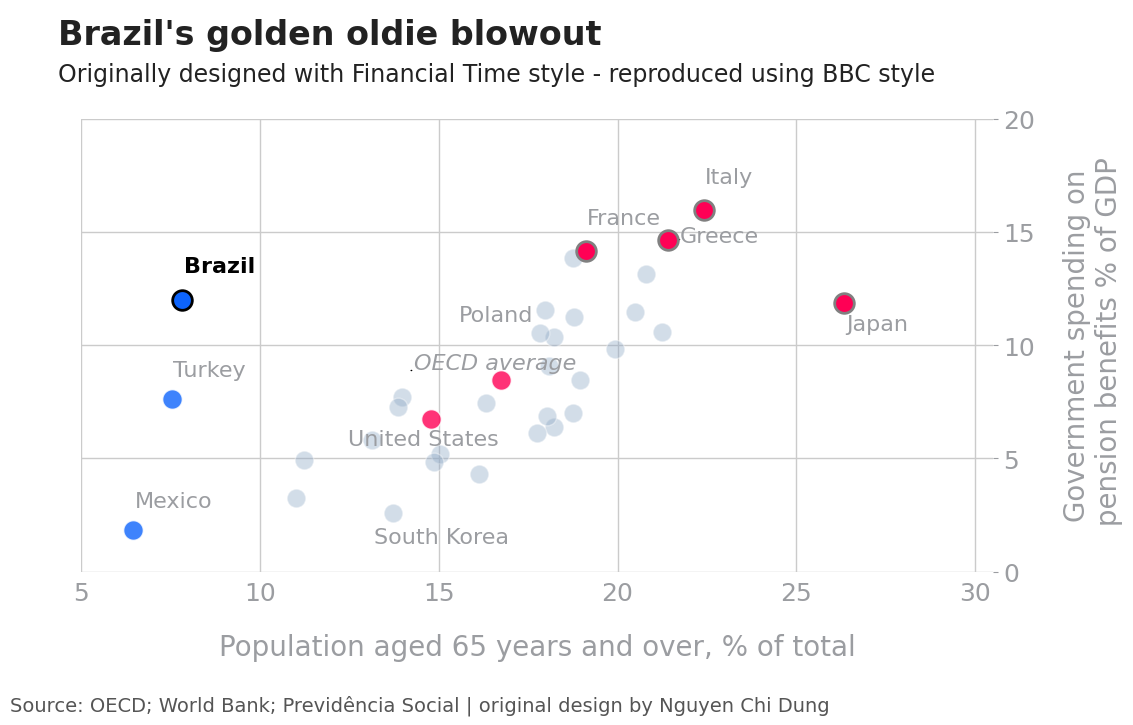

In [4]:
data = df_plot.copy()


bbc_theme()

# color palette
pink = "#ff0055"
blue1 = "#0d64fc"
bg_point = "#90aac6"
text_grey = "#9b9da1"

# split
df_bg = data[~data["is_highlight"]]
df_hl = data[data["is_highlight"]]

fig, ax = plt.subplots(figsize=(12, 7))

# all background points
ax.scatter(
    df_bg["pop_over65"],
    df_bg["gov_spending"],
    s=180,
    color=bg_point,
    edgecolors="white",
    linewidths=1,
    alpha=0.4,
)

# specific highlight groups
Brazil = data.query("country == 'Brazil'")
ax.scatter(
    Brazil["pop_over65"],
    Brazil["gov_spending"],
    s=200,
    facecolors=blue1,
    edgecolors="black",
    linewidths=2,
    zorder=3,
)
pink_countries = ["France", "Italy", "Greece", "Japan"]
pink_df = data[data["country"].isin(pink_countries)]
ax.scatter(
    pink_df["pop_over65"],
    pink_df["gov_spending"],
    s=200,
    facecolors=pink,
    edgecolors="gray",
    linewidths=2,
    zorder=3,
)
ax.scatter(
    data.query("country in ['United States', 'OECD average']").pop_over65,
    data.query("country in ['United States', 'OECD average']").gov_spending,
    s=200,
    color=pink,
    edgecolors="white",
    linewidths=1,
    alpha=0.8,
    zorder=2,
)
ax.scatter(
    data.query("country in ['Mexico', 'Turkey']").pop_over65,
    data.query("country in ['Mexico', 'Turkey']").gov_spending,
    s=200,
    color=blue1,
    edgecolors="white",
    alpha=0.8,
    zorder=2,
)

# grid & axes
ax.set_xlim(5, 30.5)
ax.set_ylim(0, 20)
ax.set_xticks(range(5, 31, 5))
ax.set_yticks(range(0, 21, 5))
# override the invisible labels:
ax.set_xlabel(
    "Population aged 65 years and over, % of total",
    fontsize=20,
    color=text_grey,
    labelpad=20,
)
ax.set_ylabel(
    "Government spending on\n pension benefits % of GDP",
    fontsize=20,
    color=text_grey,
    labelpad=20
)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.grid(True)
ax.grid(False, which="minor")

ax.tick_params(colors=text_grey)
ax.spines.values().__iter__().__next__().set_visible(False)

# labels with nudges
nudges = {
    "France": (0, 1),
    "Greece": (0.3, 0),
    "Italy": (0, 1),
    "Japan": (0, -1.3),
    "United States": (-2.4, -1.2),
    "OECD average": (-2.5, 0.4),
    "Brazil": (0, 1.1),
    "Turkey": (0, 0.9),
    "Mexico": (0, 0.9),
    "South Korea": (0, -1.3),
}
texts = []
for _, row in df_hl.iterrows():
    dx, dy = nudges.get(row["country"], (0, 0))
    txt = ax.text(
        row["pop_over65"] + dx,
        row["gov_spending"] + dy,
        row["country"],
        fontsize=16,
        fontweight="bold" if row["text_face"] == "bold" else "normal",
        fontstyle="italic" if row["text_face"] == "italic" else "normal",
        color="black" if row["country"] == "Brazil" else text_grey,
    )
    texts.append(txt)
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color="black"))

# FT‐style top‐left bar
fig.patches.append(
    patches.Rectangle(
        (0.055, 0.995),
        width=0.05 * 1.7,
        height=0.008,
        transform=fig.transFigure,
        facecolor="white",
        edgecolor="white",
        clip_on=False,
    )
)
finalise_plot(fig=fig, title="Brazil's golden oldie blowout", subtitle="Originally designed with Financial Time style - reproduced using BBC style ", source="Source: OECD; World Bank; Previdência Social | original design by Nguyen Chi Dung",
              output_path="./assets/pensions_plot.png", dpi=300)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()